In [1]:
#using Images, Colors, 
using ImageView, FileIO
include("../src/colortransfer.jl")
using ColorTransfer # requires package Images, Colors

INFO: Recompiling stale cache file /Users/chizat/.julia/lib/v0.5/Images.ji for module Images.
 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in convert(::Type{UInt32}, ::ColorTypes.RGB24) at ./deprecated.jl:50
 in copy!(::Array{UInt32,1}, ::Base.Generator{Array{ColorTypes.RGB{Float64},1},Winston.##119#120}) at ./abstractarray.jl:479
 in colormap(::Array{ColorTypes.RGB{Float64},1}) at /Users/chizat/.julia/v0.5/Winston/src/plot.jl:283
 in colormap at /Users/chizat/.julia/v0.5/Winston/src/plot.jl:287 [inlined]
 in colormap(::String) at /Users/chizat/.julia/v0.5/Winston/src/plot.jl:286
 in include_from_node1(::String) at ./loading.jl:488
 in include_from_node1(::String) at /Applications/Julia-0.5.app/Contents/Resources/julia/lib/julia/sys.dylib:?
 in include_from_node1(::String) at ./loading.jl:488
 in include_from_node1(::String) at /Applications/Julia-0.5.app/Contents/Resources/julia/lib/julia/sys.dylib:?
 in eval(::Module, ::Any) at ./boot.jl:234
 in eval(::Module, ::Any) at /Ap

# Color transfer

Starting from the idea that a color can be described by 3 real parameter, we perform unbalanced optimal transport between distributions of colors. 

Load the images. Good matches: (i) vegas/fleur

INFO: Recompiling stale cache file /Users/chizat/.julia/lib/v0.5/QuartzImageIO.ji for module QuartzImageIO.


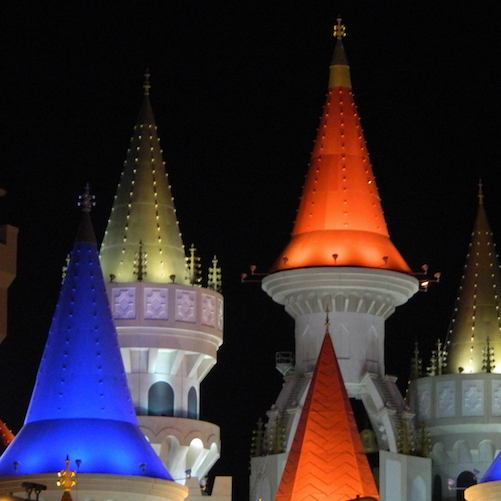

In [5]:
im_path = "../../data/images/"
img1 = load(string(im_path,"vegas.png")) # img1: image giving the color distribution

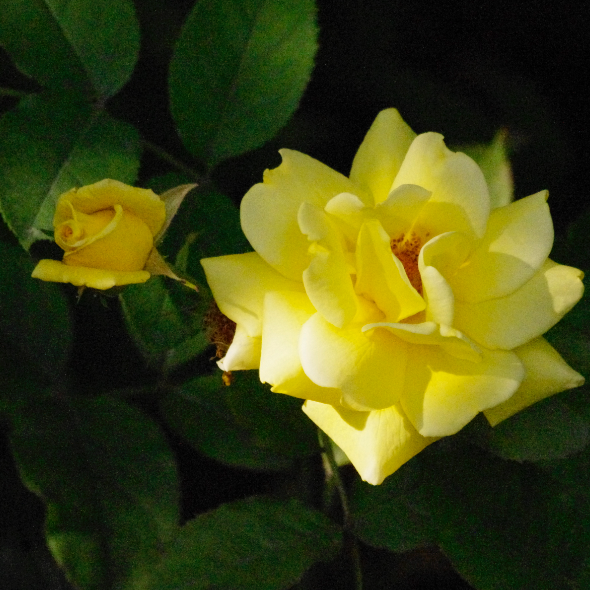

In [6]:
img2 = load(string(im_path,"fleur.png")) # target image

Compute the histograms of colors

In [123]:
colorspace = "RGB" # or LAB or LUV 
f1, f2 = im2color(img2,colorspace), im2color(img1,colorspace)
nbins = [32;32;32]; # number of bins

# Compute histograms and normalize
mins = minimum([minimum(f1,1);minimum(f2,1)],1)
maxs = maximum([maximum(f1,1);maximum(f2,1)],1)
bincenters, H1, coords1 = myhist(f1,nbins,mins=mins,maxs=maxs)
bincenters, H2, coords2 = myhist(f2,nbins,mins=mins,maxs=maxs);
H1, H2 = H1/sum(H1), H2/sum(H2);

Compute the 3d optimal transport

In [15]:
F1 = Dict(:type => "OT")
#F2 = Dict(:type => "TV", :param => .2)
#F2 = Dict(:type => "KL", :param => 0.05)
#F2 = Dict(:type => "RG", :param => (0.,5.))
#F2 = Dict(:type => "OT")
ϵ = 1e-3
@time K, a, b = convUOT(H1,H2,F1,F2,ϵ; ll= [1.; 1.; 1.], niter=1000);

147.137873 seconds (1.16 M allocations: 90.886 GB, 26.83% gc time)


Compute the transport map from the optimal plan

In [17]:
T = transportmap(a,b,K);

Apply this map to the colors

In [18]:
f′ = Float64[bincenters[j][T[j][coords1[i,:]...]] 
    for i = 1:size(coords1,1), j = 1:size(coords1,2)]
imR = color2im(f′, colorspace, img2)
#ImageView.view(imR, pixelspacing = [1,1])
#c = canvasgrid(1,3); ImageView.view(c[1,1], img1), ImageView.view(c[1,2], img2), ImageView.view(c[1,3], imR);

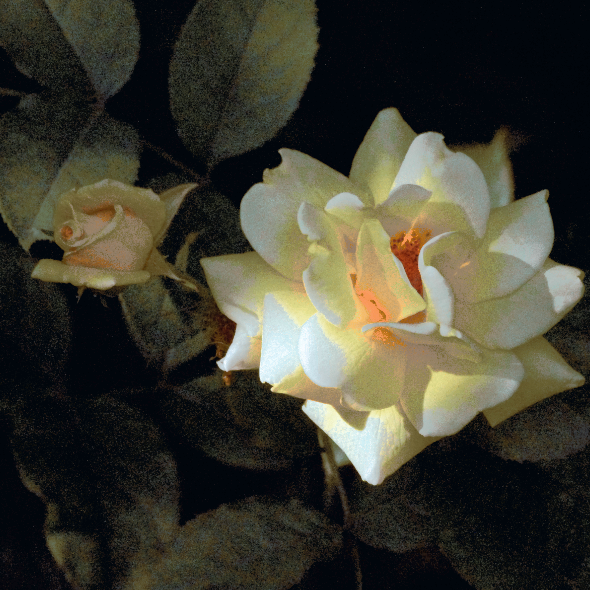

In [19]:
imR

Remarks:
- LAB color space and RGB color spaces are comparable, the result depends on the test image
- There's apparently not a great interest in adding anisotropy in the color space


In [30]:
#save("outputs/fleur_vegas_RG0_5.png",imR)

# Plot the 3d color histograms

In [2]:
using PyPlot

In [4]:
?scatter3D

search: scatter3D scatter




        Create a scatter plot.

        ============  ========================================================
        Argument      Description
        ============  ========================================================
        *xs*, *ys*    Positions of data points.
        *zs*          Either an array of the same length as *xs* and
                      *ys* or a single value to place all points in
                      the same plane. Default is 0.
        *zdir*        Which direction to use as z ('x', 'y' or 'z')
                      when plotting a 2D set.
        *s*           Size in points^2.  It is a scalar or an array of the
                      same length as *x* and *y*.

        *c*           A color. *c* can be a single color format string, or a
                      sequence of color specifications of length *N*, or a
                      sequence of *N* numbers to be mapped to colors using the
                      *cmap* and *norm* specified via kwargs (see b

In [32]:
maximum(H1[1:10,10:20,38])

0.005461074403906923

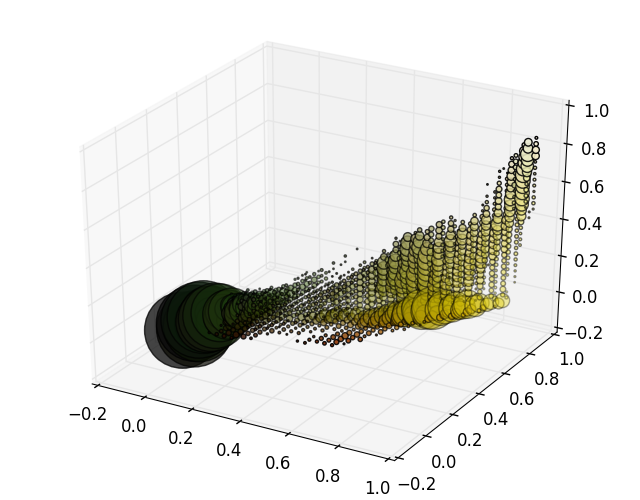

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x3263d1350>

In [170]:
ax = scatter3D(X,Y,Z,s=S,c=cat(2,X,Y,Z));
#ax.grid(linewidth=20)
#savefig("../output/colortransfer/histfleur")

In [169]:
th = 1*1e-5
nn = sum(H1.>th)
X,Y,Z,S = ntuple(n->zeros(nn),4)
n = 1
for i= 1:size(H1,1)
    for j= 1:size(H1,2)
        for k= 1:size(H1,3)
            if H1[i,j,k]>th
                X[n] = bincenters[1][i]
                Y[n] = bincenters[2][j]
                Z[n] = bincenters[3][k]
                S[n] = min(3000,H1[i,j,k]/th)
                n+=1
            end
        end
    end
end

In [ ]:
Cartesianrange(size(H1))